# Enjoy

In [20]:
import numpy as np
from numpy.random import choice
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
import yfinance as yf

In [21]:
df = pdr.get_data_yahoo("AAPL", start="2019-01-01" , end = '2021-01-01')

In [22]:
short_window = int(0.025 * len(df))
long_window = int(0.07 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
# calculate moving average
signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()
# use scale of short ma and long ma as trading signal
signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0) 
# switch from one signal to another
signals['positions_change'] = signals['signal'].diff() 

signals

,signal,short_ma,long_ma,positions_change
Date,,,,
2019-01-02,0.0,39.480000,39.480000,NaN
2019-01-03,0.0,37.513750,37.513750,0.0
2019-01-04,0.0,37.364166,37.364166,0.0
2019-01-07,0.0,37.268749,37.268749,0.0
2019-01-08,0.0,37.352499,37.352499,0.0
...,...,...,...,...
2020-12-24,1.0,126.941667,121.850857,0.0
2020-12-28,1.0,128.184167,122.355429,0.0
2020-12-29,1.0,129.153334,122.817714,0.0


In [23]:
def buy_stock(
    historical_movement,
    signal,
    initial_money = 10000,
    max_buy = 15,
    max_sell = 10,
):
    """
    when the signal is on, the agent trade random shares from range(max_buy) and range(max_share)
    
    historical_movement = historical movement
    min_holding_period = minimum interval between decision of buy and sell, vice versa
    state = 1 is buy, 0 is sell
    initial_money = 10000
    max_buy = max shares to buy, i long the market and growth of market thus i set max buy > max sell
    max_sell = max shares to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // historical_movement[i]
        if shares < 1:
            print(
                'day {}: total remain balances {:.2f}, not enough money to buy a unit price {:.2f}'
                .format (i, initial_money, historical_movement[i])
            )
        else:
            current_buy = choice (range(2,max_buy+1))
            if shares > current_buy:
                buy_units = current_buy
            else:
                buy_units = shares
            initial_money -= buy_units * historical_movement[i]
            current_inventory += buy_units
            print(
                'day {}: buy {} units at price {:.2f}, total remain balance {:.2f}'
                .format(i, buy_units, buy_units * historical_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(historical_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day {}: cannot sell anything, inventory 0' .format (i))
            else:
                current_sell = choice(range(1,max_sell+1))
                if current_inventory > current_sell:
                    sell_units = current_sell
                else:
                    sell_units = choice(range(1,current_inventory+1))
                current_inventory -= sell_units
                total_sell = sell_units * historical_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (historical_movement[i] - historical_movement[states_buy[-1]])
                        / historical_movement[states_buy[-1]]
                    ) 
                except:
                    invest = 0
                print(
                    'day {}: sell {} units at price {:.2f}, investment {:.2%}, total remain balance {:.2f},'
                    .format (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    initial_money += current_inventory * historical_movement.iloc[-1]
    invest = ((initial_money - starting_money) / starting_money) 
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [24]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions_change'])

day 13: buy 9 units at price 344.93, total remain balance 9655.07
day 94: sell 5 units at price 236.25, investment 23.29%, total remain balance 9891.32,
day 116: buy 11 units at price 544.14, total remain balance 9347.18
day 155: sell 6 units at price 304.12, investment 2.47%, total remain balance 9651.31,
day 161: buy 7 units at price 371.81, total remain balance 9279.50
day 289: sell 3 units at price 219.49, investment 37.74%, total remain balance 9498.99,
day 324: buy 4 units at price 286.69, total remain balance 9212.30
day 432: sell 1 units at price 106.84, investment 49.07%, total remain balance 9319.14,
day 451: buy 13 units at price 1569.23, total remain balance 7749.91
day 464: sell 7 units at price 773.08, investment -8.51%, total remain balance 8522.99,
day 474: buy 10 units at price 1193.90, total remain balance 7329.09


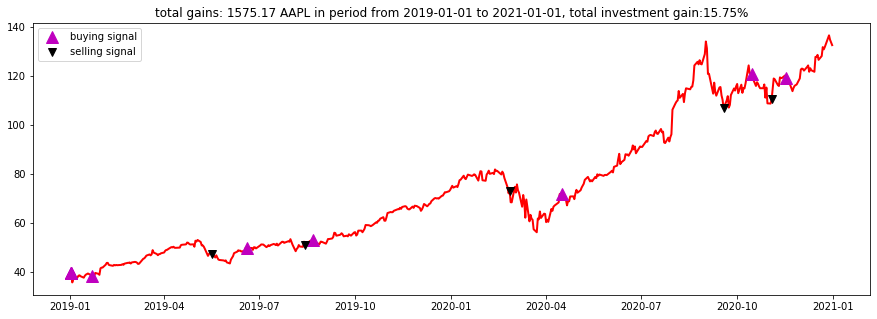

In [26]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=12, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=8, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains: {:.2f} AAPL in period from 2019-01-01 to 2021-01-01, total investment gain:{:.2%}'.format(total_gains, invest))
plt.legend()
plt.show()